<a href="https://colab.research.google.com/github/krishghiya/Coronavirus-Diagnosis-ML/blob/master/server/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [41]:
# !pip install pyspark

# import pyspark
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

os.environ['KAGGLE_USERNAME'] = 'sunstorm7'
os.environ['KAGGLE_KEY'] = 'cab6333039c1305d621a55f8b91ce30f'

# China data from rupsikaushik/covid19-patientlevel-data removed
# Vietnam data from nhntran/vietnam-covid19-patient-dataset removed
# Global data from shirmani/characteristics-corona-patients removed

# County statistical data
# county_data = keras.utils.get_file('us-counties.csv', 'https://github.com/nytimes/covid-19-data/raw/master/live/us-counties.csv')

In [42]:
# Plotting function used multiple times for correlation of categorical data

def plot(x, y, data, ax):
  cols = data.columns
  g = sns.countplot(x=cols[x], hue=cols[y], data=data, ax=ax)
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
  return g

# Training Data Preprocessing

## Mexico data processing

In [43]:
!kaggle datasets download -d tanmoyx/covid19-patient-precondition-dataset --unzip
mexico_df = pd.read_csv('covid.csv')


  0%|          | 0.00/7.56M [00:00<?, ?B/s]
 13%|#3        | 1.00M/7.56M [00:00<00:03, 2.18MB/s]
 26%|##6       | 2.00M/7.56M [00:00<00:02, 2.85MB/s]
 66%|######6   | 5.00M/7.56M [00:00<00:00, 3.89MB/s]
100%|##########| 7.56M/7.56M [00:00<00:00, 10.5MB/s]


In [44]:
mexico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [45]:
cols = ['sex', 'age', 'pneumonia', 'pregnancy', 'diabetes', 'copd', 'asthma', 'hypertension', 'inmsupr', 'other_disease', 
                       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'covid_res']
mexico_df = mexico_df[cols]
cols.remove('sex')
cols.remove('age')
mexico_df[cols] = mexico_df[mexico_df[cols] < 3][cols]
mexico_df['pregnancy'] = mexico_df['pregnancy'].fillna(1)
mexico_df.dropna(inplace=True)
mexico_df[cols] = mexico_df[cols] == 1
mexico_df['male'] = mexico_df['sex'] == 2
del mexico_df['sex']
mexico_df.rename(columns={'inmsupr': 'Immunosuppression',
                          'renal_chronic': 'Kidney Disease',
                          'copd': "Breathing difficulty",
                          'other_disease': 'Other diseases',
                          'pregnancy': 'Pregnant'}, inplace=True)
mexico_df.columns = [s.capitalize() for s in mexico_df.columns]
mexico_df.rename(columns={'Covid_res': 'COVID-19'}, inplace=True)

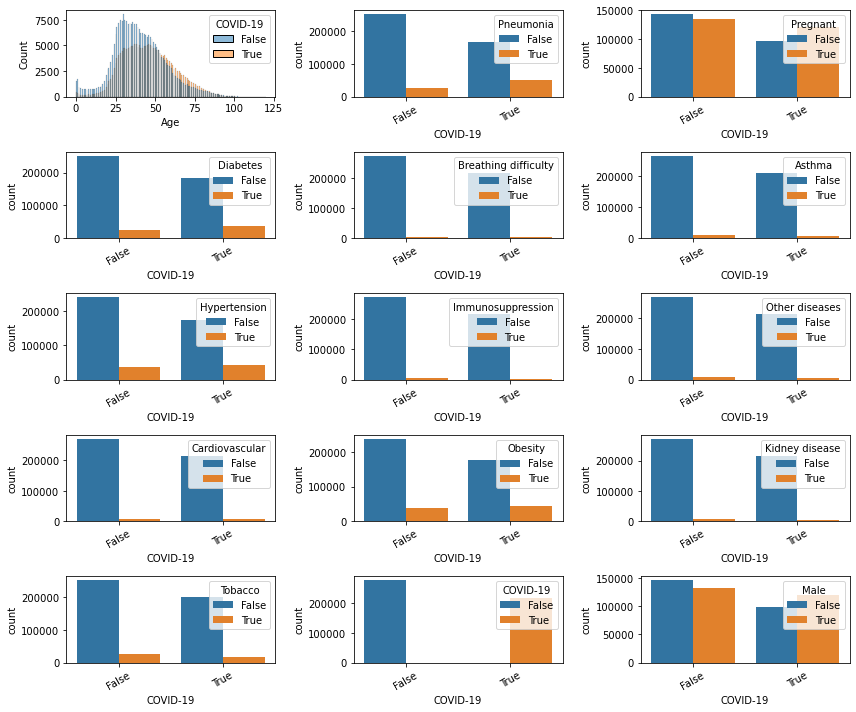

In [46]:
cols = mexico_df.columns
fig, axes = plt.subplots(5,3, figsize=(12,10))
axes = axes.flatten()

for i, col in enumerate(cols):
  if col != 'Age':
    plot(-2, i, mexico_df, axes[i])
sns.histplot(x='Age', hue='COVID-19', ax=axes[0], data=mexico_df)

plt.tight_layout()
plt.show()

## Brazil data processing

In [47]:
!kaggle datasets download -d cprete/covid19-open-datasets-for-brazil --unzip
brazil_sars_df = pd.read_csv('SARS_01-06/SRAG_01-06.csv', sep=';')


  0%|          | 0.00/139M [00:00<?, ?B/s]
  1%|          | 1.00M/139M [00:00<01:09, 2.08MB/s]
  2%|2         | 3.00M/139M [00:00<00:50, 2.79MB/s]
  5%|5         | 7.00M/139M [00:00<00:35, 3.88MB/s]
  8%|7         | 11.0M/139M [00:00<00:25, 5.32MB/s]
 10%|#         | 14.0M/139M [00:01<00:19, 6.62MB/s]
 12%|#2        | 17.0M/139M [00:01<00:14, 8.61MB/s]
 14%|#4        | 20.0M/139M [00:01<00:14, 8.50MB/s]
 17%|#6        | 23.0M/139M [00:01<00:11, 10.6MB/s]
 19%|#9        | 27.0M/139M [00:01<00:08, 13.6MB/s]
 23%|##3       | 32.0M/139M [00:01<00:06, 17.4MB/s]
 27%|##7       | 38.0M/139M [00:01<00:04, 22.0MB/s]
 32%|###2      | 45.0M/139M [00:02<00:03, 27.4MB/s]
 37%|###6      | 51.0M/139M [00:02<00:02, 32.7MB/s]
 41%|####1     | 57.0M/139M [00:02<00:02, 37.9MB/s]
 45%|####5     | 63.0M/139M [00:02<00:01, 42.5MB/s]
 50%|#####     | 70.0M/139M [00:02<00:01, 47.1MB/s]
 55%|#####4    | 76.0M/139M [00:02<00:01, 50.5MB/s]
 59%|#####9    | 82.0M/139M [00:02<00:01, 50.1MB/s]
 63%|######3   | 88.

C:\Users\Checkout\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,60,62,63,64,109,111,127,135,137,138,139,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [48]:
idx = [12, 14, 15, 17, 18, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 126]
cols = ['Sex','Age', 'Age Type', 'Pregnant', 'Race', 'Fever', 'Cough', 'Throat infection', 'Breathing difficulty', 'Respiratory', 'Low oxygen levels', 
        'Diarrhea', 'Vomiting', 'Additional Symptoms', 'Cardiovascular', 'Hematologic (Blood Disease)', 'Down Syndrome', 'Liver disease', 'Asthma',
        'Diabetes', 'Neurological', 'Pneumonia', 'Immunosuppression', 'Kidney disease', 'Obesity', 'COVID-19']

In [49]:
brazil_sars_df = brazil_sars_df.iloc[:, idx]
brazil_sars_df.columns = cols

In [50]:
brazil_sars_df['COVID-19'] = brazil_sars_df['COVID-19'] == 5.0
brazil_sars_df['Age'].where(brazil_sars_df['Age Type'] == 3, inplace=True, other=1)
del brazil_sars_df['Age Type']
brazil_sars_df['Myalgia'] = brazil_sars_df['Additional Symptoms'] == "MIALGIA"
brazil_sars_df['Headache'] = brazil_sars_df['Additional Symptoms'] == "CEFALEIA"
del brazil_sars_df['Additional Symptoms']
brazil_sars_df['Sex'].where(brazil_sars_df['Sex'] == 'I', inplace=True, other='M')
brazil_sars_df['Male'] = brazil_sars_df['Sex'] == 'M'
del brazil_sars_df['Sex']
brazil_sars_df['Pregnant'].where(brazil_sars_df['Pregnant'] < 5, inplace=True, other=False)
brazil_sars_df['Pregnant'] = brazil_sars_df['Pregnant'] != 0
brazil_sars_df.iloc[:, 3:-4] = brazil_sars_df.iloc[:, 3:-4] == 1.
brazil_sars_df['Race'].where(brazil_sars_df['Race'] != 9, inplace=True, other=2)
brazil_sars_df['Race'].where(brazil_sars_df['Race'] != 5, inplace=True, other=4)
brazil_sars_df['Race'].replace([1.,2.,3.,4.], ["White", "Black", "Asian", "Hispanic/Latino"], inplace=True)

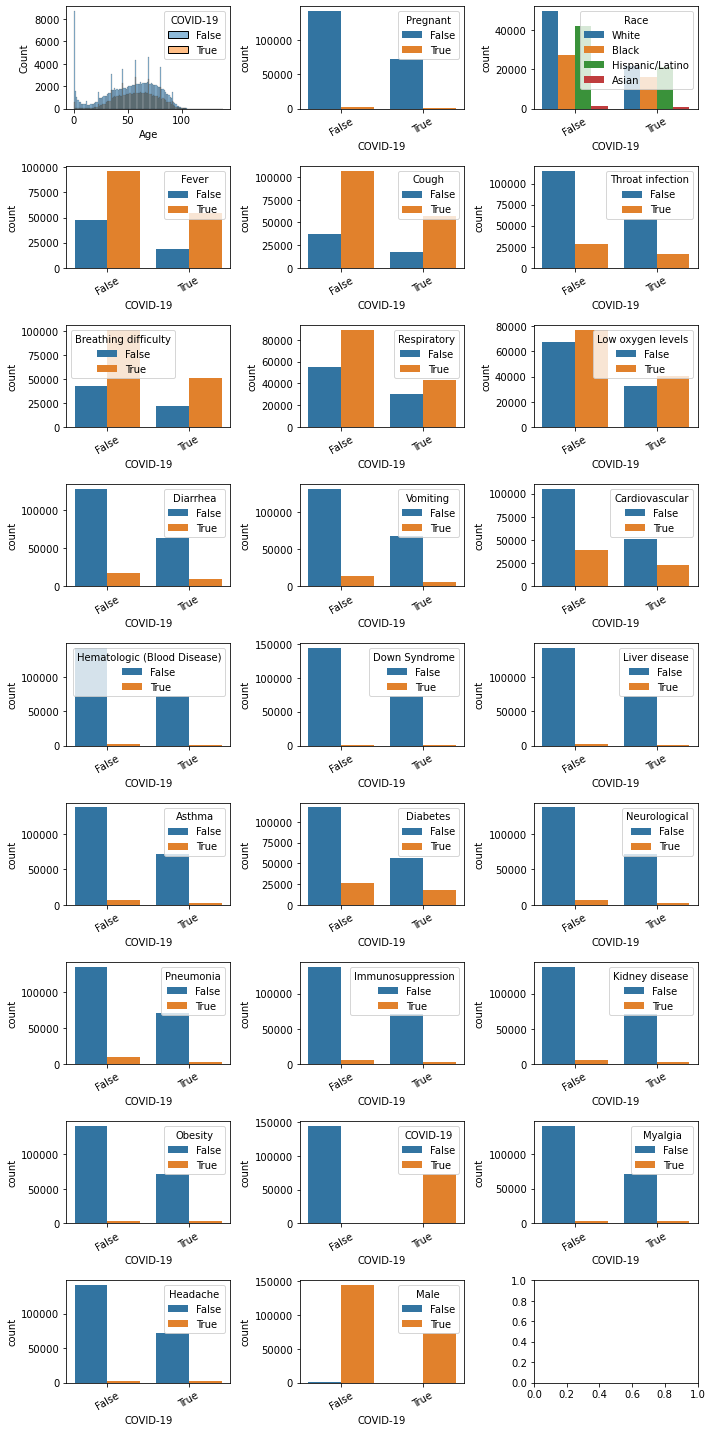

In [51]:
cols = brazil_sars_df.columns
fig, axes = plt.subplots(9,3, figsize=(10,20))
axes = axes.flatten()

for i, col in enumerate(cols):
  if col != "Age":
    plot(-4, i, brazil_sars_df, axes[i])
sns.histplot(hue='COVID-19', x='Age', data=brazil_sars_df, ax=axes[0])

plt.tight_layout()
plt.show()

In [52]:
# One Hot Encode Race

brazil_sars_df = pd.get_dummies(brazil_sars_df, drop_first=True)

## Israel data processing

In [53]:
keras.utils.get_file('israel.zip', 'https://github.com/nshomron/covidpred/blob/master/data/corona_tested_individuals_ver_0083.english.csv.zip?raw=true',
                     extract=True, cache_dir='./', cache_subdir='')
israel_df = pd.read_csv('corona_tested_individuals_ver_0083.english.csv')

C:\Users\Checkout\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [54]:
israel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742596 entries, 0 to 2742595
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                int64 
 2   fever                int64 
 3   sore_throat          int64 
 4   shortness_of_breath  int64 
 5   head_ache            int64 
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: int64(5), object(5)
memory usage: 209.2+ MB


In [55]:
israel_df.drop(labels=['test_date', 'test_indication'], inplace=True, axis=1)
israel_df['age_60_and_above'] = israel_df['age_60_and_above'] == "Yes"
israel_df['corona_result'] = israel_df['corona_result'] == "positive"
israel_df['Male'] = israel_df['gender'] == "male"
del israel_df['gender']
israel_df.rename(columns={'sore_throat': 'Sore Throat',
                          'head_ache': 'Headache',
                          'age_60_and_above': 'Age above 60',
                          'shortness_of_breath': 'Breathing difficulty'}, 
                 inplace=True)
israel_df.columns = [s.capitalize() for s in israel_df.columns]
israel_df.rename(columns={'Corona_result': 'COVID-19'}, inplace=True)

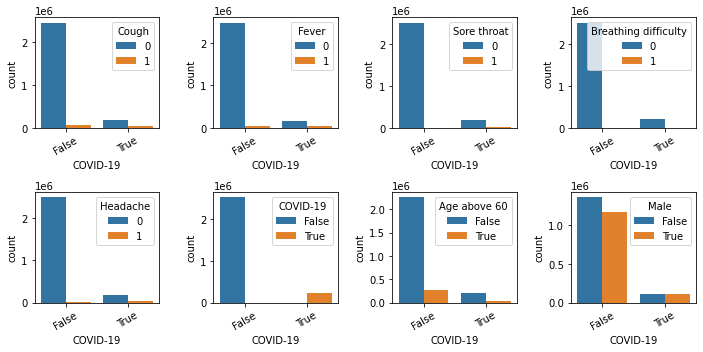

In [56]:
cols = israel_df.columns
fig, axes = plt.subplots(2,4, figsize=(10,5))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(5, i, israel_df, axes[i])

plt.tight_layout()
plt.show()

# Model Training and Comparison

In [57]:
def train_and_evaluate(clf, df, metric, train=True):
  X, y = mexico_df.drop(['COVID-19'], axis=1), mexico_df['COVID-19']
  if train:
    clf.fit(X, y)
  return metric(clf.predict(X), y)

## Mexico Dataset Models

### Support Vector Machine (SVM) - Training Too Slow

In [ ]:
mexico_svm = SVC(random_state=42, kernel='linear', verbose=1)
# train_and_evaluate(mexico_svm, mexico_df, recall_score)

[LibSVM]

### K-Means Clustering

In [71]:
mexico_kmeans = KMeans(n_clusters=2, verbose=0, n_init=3, init='k-means++')
train_and_evaluate(mexico_kmeans, mexico_df, recall_score)

0.525377249711736

In [ ]:
train_and_evaluate(mexico_kmeans, mexico_df, precision_score, train=False)

### Random Forest

In [29]:
mexico_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(mexico_rf, mexico_df, recall_score)

0.37450548647339904

In [79]:
train_and_evaluate(mexico_rf, mexico_df, precision_score, train=False)

0.37450548647339904

### Gradient Boosted Decision Tree (XGBoost)

In [28]:
mexico_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(mexico_xgb, mexico_df, recall_score)

0.34783601794410285

In [ ]:
train_and_evaluate(mexico_xgb, mexico_df, precision_score, train=False)

### Multi Layer Perceptron (MLP)

In [ ]:
X, y = mexico_df.drop(['COVID-19'], axis=1).astype(np.float32), mexico_df['COVID-19']
# X = np.expand_dims(X.values, 0)

model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
epochs=50
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer="Nadam", metrics=["Precision", "Recall"])
history = model.fit(X, y, epochs=epochs, batch_size=32)

## Brazil Dataset Models

### Support Vector Machine (SVM) - Training too Slow

In [ ]:
brazil_svm = SVC(random_state=42, kernel='linear', verbose=2)
train_and_evaluate(brazil_svm, brazil_sars_df, recall_score)

[LibSVM]

### K-Means Clustering

In [85]:
brazil_kmeans = KMeans(n_clusters=2, verbose=0, n_init=10)
train_and_evaluate(brazil_kmeans, brazil_sars_df, recall_score)

0.5222584508916689

In [86]:
train_and_evaluate(brazil_kmeans, brazil_sars_df, precision_score, train=False)

0.5019552128349672

### Random Forest

In [87]:
brazil_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(brazil_rf, brazil_sars_df, recall_score)

0.6784345854332696

In [88]:
train_and_evaluate(brazil_rf, brazil_sars_df, precision_score, train=False)

0.37450548647339904

### Gradient Boosted Decision Tree (XGBoost)

In [90]:
brazil_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(brazil_xgb, brazil_sars_df, recall_score)

0.6397304699971433

In [91]:
train_and_evaluate(brazil_xgb, brazil_sars_df, precision_score, train=False)

0.34783601794410285

## Israel Dataset Models

### Support Vector Machine (SVM) - Training too Slow

In [99]:
mexico_svm = SVC(random_state=42, kernel='linear', verbose=2)
# train_and_evaluate(mexico_svm, mexico_df, recall_score)

### K-Means Clustering

In [93]:
israel_kmeans = KMeans(n_clusters=2, verbose=0, n_init=3)
train_and_evaluate(israel_kmeans, israel_df, recall_score)

0.525377249711736

In [94]:
train_and_evaluate(israel_kmeans, israel_df, precision_score, train=False)

0.47873934454687483

### Random Forest

In [95]:
israel_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(israel_rf, israel_df, recall_score)

0.6784345854332696

In [96]:
train_and_evaluate(israel_rf, israel_df, precision_score, train=False)

0.37450548647339904

### Gradient Boosted Decision Tree (XGBoost)

In [97]:
israel_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(israel_xgb, israel_df, recall_score)

0.6397304699971433

In [98]:
train_and_evaluate(israel_xgb, israel_df, precision_score, train=False)

0.34783601794410285

# Testing Data Preprocessing

## India Synthetic Data

In [ ]:
!kaggle datasets download -d prakharsrivastava01/covid19-symptoms-dataset --unzip

  0% 0.00/7.05k [00:00<?, ?B/s]
100% 7.05k/7.05k [00:00<00:00, 6.10MB/s]


In [ ]:
india_test_df = pd.read_excel('covid19-symptoms-dataset.xlsx')

In [ ]:
india_test_df.head()

,Dry Cough,High Fever,Sore Throat,Difficulty in breathing,Infected with Covid19
0,0,2,3,0,No
1,15,15,20,16,Yes
2,4,5,0,0,No
3,4,7,9,10,No
4,0,0,1,0,No


In [ ]:
india_test_df.iloc[:, :-1] = india_test_df.iloc[:, :-1] != 0
india_test_df.iloc[:, -1] = india_test_df.iloc[:, -1] == "Yes" 

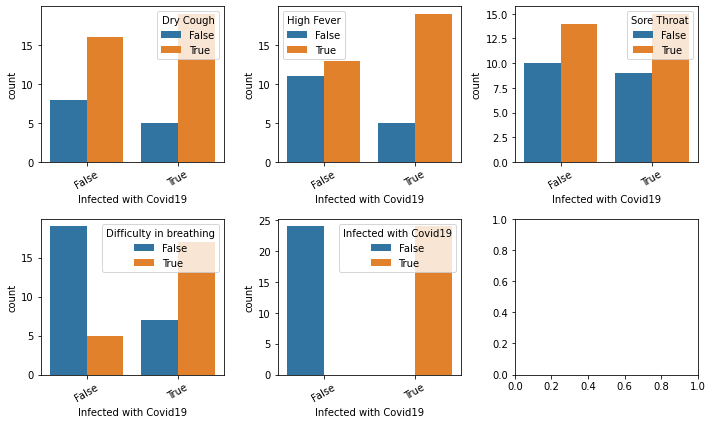

In [ ]:
cols = india_test_df.columns
fig, axes = plt.subplots(2,3, figsize=(10,6))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(-1, i, india_test_df, axes[i])

plt.tight_layout()
plt.show()

## India WHO Synthetic Data

In [ ]:
!kaggle datasets download -d hemanthhari/symptoms-and-covid-presence --unzip

  0% 0.00/25.8k [00:00<?, ?B/s]
100% 25.8k/25.8k [00:00<00:00, 42.7MB/s]


In [ ]:
india_who_test_df = pd.read_csv('Covid Dataset.csv')

In [ ]:
india_who_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Breathing Problem                        5434 non-null   object
 1   Fever                                    5434 non-null   object
 2   Dry Cough                                5434 non-null   object
 3   Sore throat                              5434 non-null   object
 4   Running Nose                             5434 non-null   object
 5   Asthma                                   5434 non-null   object
 6   Chronic Lung Disease                     5434 non-null   object
 7   Headache                                 5434 non-null   object
 8   Heart Disease                            5434 non-null   object
 9   Diabetes                                 5434 non-null   object
 10  Hyper Tension                            5434 non-null   obj

In [ ]:
india_who_test_df = india_who_test_df.iloc[:, np.r_[:13, 20]]
india_who_test_df = india_who_test_df == "Yes"

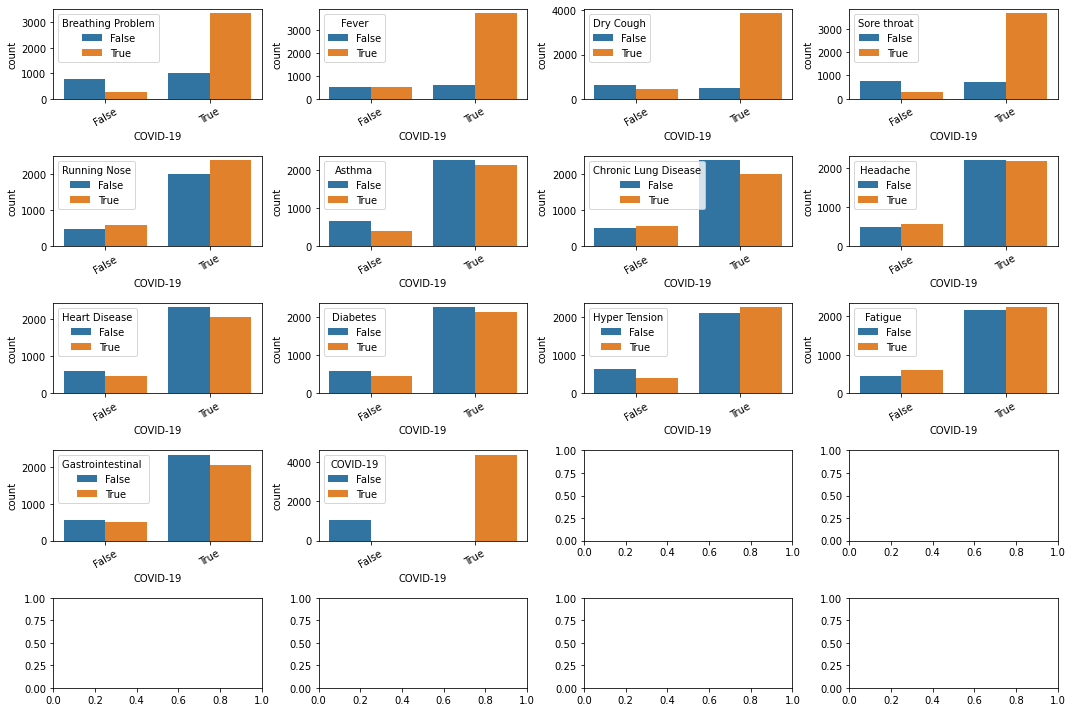

In [ ]:
cols = india_who_test_df.columns
fig, axes = plt.subplots(5,4, figsize=(15,10))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(-1, i, india_who_test_df, axes[i])

plt.tight_layout()
plt.show()

## US Mayo Clinic Synthetic Data

In [ ]:
!kaggle datasets download -d walterconway/covid-flu-cold-symptoms --unzip

  0% 0.00/210k [00:00<?, ?B/s]
100% 210k/210k [00:00<00:00, 77.7MB/s]


In [ ]:
us_mayo_test_df = pd.read_csv('large_data.csv')

In [ ]:
us_mayo_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44453 entries, 0 to 44452
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 44453 non-null  int64 
 1   MUSCLE_ACHES          44453 non-null  int64 
 2   TIREDNESS             44453 non-null  int64 
 3   SORE_THROAT           44453 non-null  int64 
 4   RUNNY_NOSE            44453 non-null  int64 
 5   STUFFY_NOSE           44453 non-null  int64 
 6   FEVER                 44453 non-null  int64 
 7   NAUSEA                44453 non-null  int64 
 8   VOMITING              44453 non-null  int64 
 9   DIARRHEA              44453 non-null  int64 
 10  SHORTNESS_OF_BREATH   44453 non-null  int64 
 11  DIFFICULTY_BREATHING  44453 non-null  int64 
 12  LOSS_OF_TASTE         44453 non-null  int64 
 13  LOSS_OF_SMELL         44453 non-null  int64 
 14  ITCHY_NOSE            44453 non-null  int64 
 15  ITCHY_EYES            44453 non-null

In [ ]:
us_mayo_test_df['COVID-19'] = us_mayo_test_df['TYPE'] == "COVID"
del us_mayo_test_df['TYPE']

In [ ]:
us_mayo_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44453 entries, 0 to 44452
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 44453 non-null  int64
 1   MUSCLE_ACHES          44453 non-null  int64
 2   TIREDNESS             44453 non-null  int64
 3   SORE_THROAT           44453 non-null  int64
 4   RUNNY_NOSE            44453 non-null  int64
 5   STUFFY_NOSE           44453 non-null  int64
 6   FEVER                 44453 non-null  int64
 7   NAUSEA                44453 non-null  int64
 8   VOMITING              44453 non-null  int64
 9   DIARRHEA              44453 non-null  int64
 10  SHORTNESS_OF_BREATH   44453 non-null  int64
 11  DIFFICULTY_BREATHING  44453 non-null  int64
 12  LOSS_OF_TASTE         44453 non-null  int64
 13  LOSS_OF_SMELL         44453 non-null  int64
 14  ITCHY_NOSE            44453 non-null  int64
 15  ITCHY_EYES            44453 non-null  int64
 16  ITCH

## US CDC Data - All positive

In [ ]:
!kaggle datasets download -d arashnic/covid19-case-surveillance-public-use-dataset
us_df = pd.read_csv('covid19-case-surveillance-public-use-dataset.zip') 

 72% 33.0M/46.0M [00:01<00:00, 21.6MB/s]
100% 46.0M/46.0M [00:01<00:00, 43.2MB/s]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 705.4+ MB


In [ ]:
us_df = us_df[['sex', 'age_group', 'Race and ethnicity (combined)', 'medcond_yn']].dropna()
us_df = us_df[~us_df.isin(["Missing", "Unknown", "Other"])]
us_df['Race and ethnicity (combined)'] = us_df['Race and ethnicity (combined)'].str.split(',').str[0]
us_df['Race and ethnicity (combined)'] = us_df['Race and ethnicity (combined)'].str.split('/').str[0]
us_df['age_group'] = us_df['age_group'].str.split(' Y').str[0]

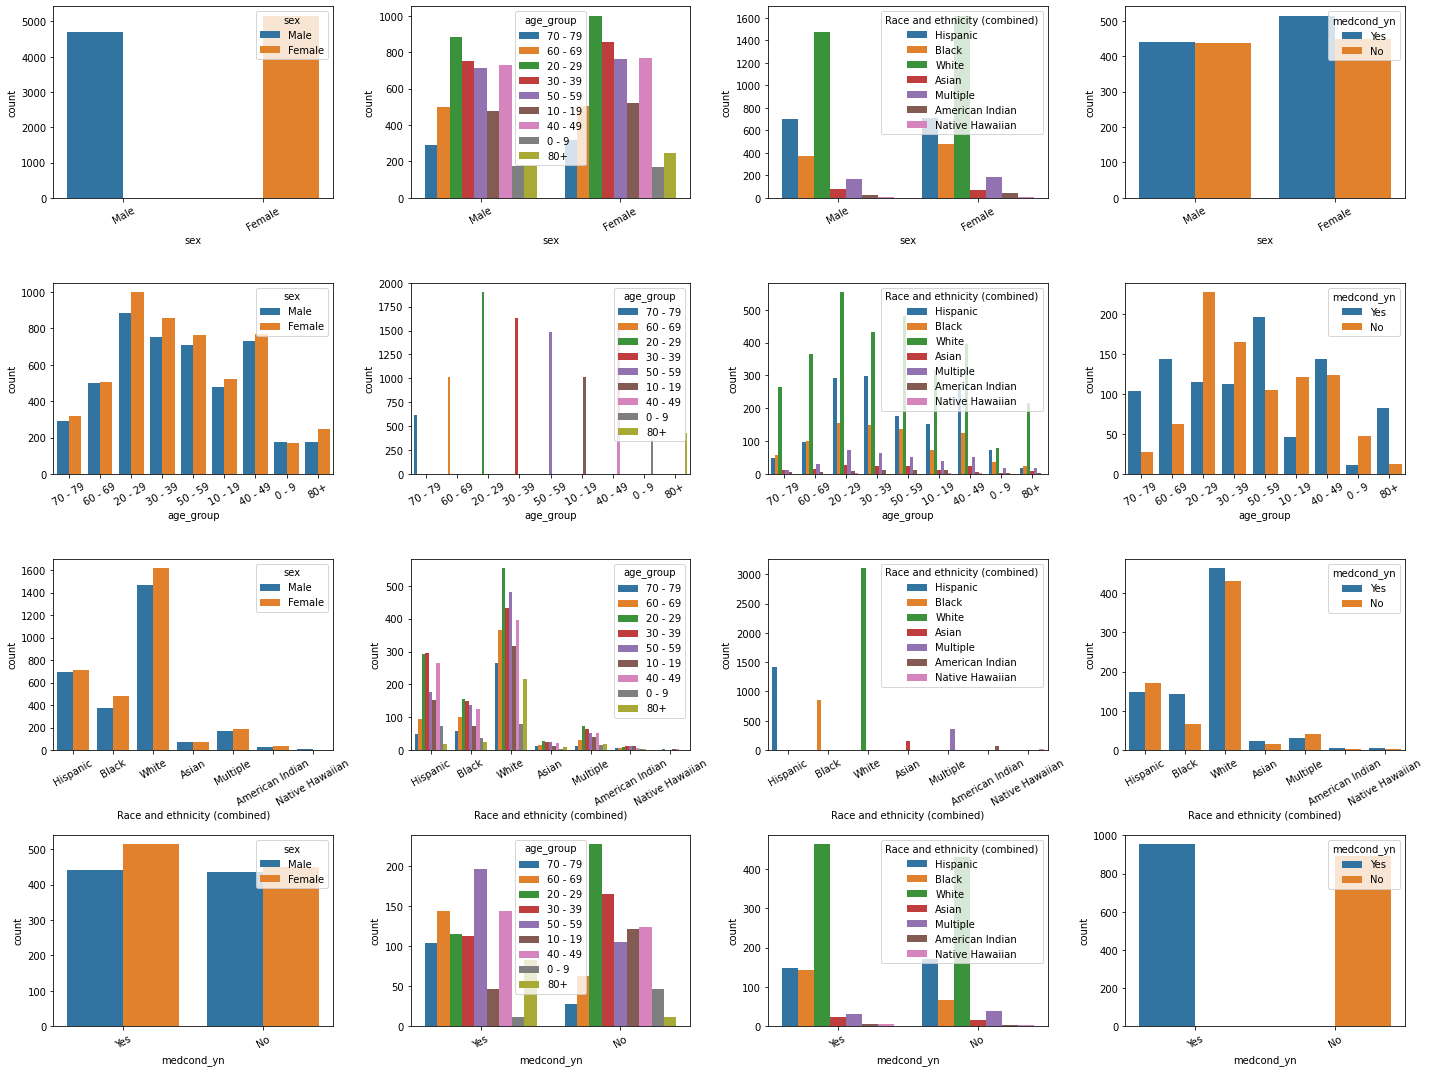

In [ ]:
cols = us_df.columns
fig, axes = plt.subplots(4,4, figsize=(20,15))
for i, col in enumerate(cols):
  for j, col2 in enumerate(cols):
    plot(i, j, us_df.sample(10000, random_state=42), axes[i][j])

plt.tight_layout()
plt.show()